# LSTM Model


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, TensorDataset
#from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {device}")

Using cpu


### Prepare the Data

We begin by loading the preprocessed dataset from a CSV file. The index_col=[0] parameter sets the first column as the index of the DataFrame.

In [34]:
data = pd.read_csv("../data/final/preprocessed_full.csv", index_col=[0])

To ensure consistency and normalize the range of the target variable, we apply MinMax scaling to the net_migration column. The original minimum and maximum values (omin and omax) are stored for potential later use.

In [35]:
omin, omax = -2, 2
data["net_migration"] = minmax_scale(data["net_migration"])

Next, we remove data from the years 2022 and 2023, focusing our analysis on data up to the year 2021.

In [36]:
data = data[data["year"] < 2022]

The data is sorted by the country code (iso3) and year to ensure that each country’s data is ordered chronologically. The index is then reset to ensure that it is sequential and clean.

In [37]:
data = data.sort_values(["iso3", "year"]).reset_index(drop=True)

Here, we create a new column net_migration_tp1 that represents the next year's net migration value. This is done using the shift method. Rows where this value is not available (e.g., the last year in each country's data) are dropped.

In [38]:
data["net_migration_tp1"] = data.groupby(by="iso3").shift(-1)["net_migration"]
data = data.dropna(subset="net_migration_tp1")

The target variable for our model is defined as net_migration_tp1. We also define the feature set by selecting all numeric columns except iso3, year, and the target variable.

In [39]:
target = "net_migration_tp1"

features = data.drop(["iso3", "year", target], axis=1).select_dtypes(include=[np.number]).columns.tolist()

The create_sequences function generates sequences of data for input into the model. For each country (iso3), it creates sequences of a specified length (seq_length). Each sequence is paired with the corresponding target value (net_migration_tp1).

In [40]:
def create_sequences(df: pd.DataFrame, seq_length: int) -> list:
    sequences = []
    for _, group in df.groupby("iso3"):
        for i in range(len(group) - seq_length):
            seq = group.iloc[i:i+seq_length][features].values
            target = group.iloc[i+seq_length]["net_migration_tp1"]
            sequences.append((seq.astype(np.float32), float(target)))
    return sequences

A custom dataset class, MigrationDataset, is created to handle the sequences. It inherits from PyTorch's Dataset class, allowing it to be easily used with DataLoaders. The __getitem__ method ensures that each sequence and target pair is returned as a PyTorch tensor.

In [41]:
class MigrationDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x, y = self.sequences[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

The data is split into training, validation, and test sets based on a predefined 'set' column. This ensures that each set is used appropriately for model training, validation, and testing.

In [42]:
data_train = data[data['set'] == 'train']
data_val = data[data['set'] == 'val']
data_test = data[data['set'] == 'test']

The sequence length is set to 1. This means each input sequence will consist of a single time step's features. The create_sequences function is applied to the training, validation, and test sets to generate sequences for each set.

In [43]:
seq_length = 1
train_seqs = create_sequences(data_train, seq_length)
val_seqs = create_sequences(data_val, seq_length)
test_seqs = create_sequences(data_test, seq_length)

Using the MigrationDataset class, we create dataset objects for the training, validation, and test sets.

In [44]:
train_set = MigrationDataset(train_seqs)
val_set = MigrationDataset(val_seqs)
test_set = MigrationDataset(test_seqs)

Finally, DataLoaders are created for each dataset. The batch_size is set to 32, and the training data is shuffled to ensure that the model does not learn the order of the data.

In [45]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

### Defining and Training the Model

This class defines the LSTM-based neural network model. It includes an LSTM layer with num_layers and a specified hidden_size, followed by a fully connected layer (fc) that maps the LSTM outputs to the desired output size. A dropout layer is also included to prevent overfitting.

In [46]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Here, we initialize the model with specific hyperparameters, such as the input_size, hidden_size, num_layers, and output_size.

In [47]:
input_size = len(train_seqs[0][0][0])
hidden_size = 128
num_layers = 2
output_size = 1

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)

We use the Huber loss function, which is robust to outliers, and the Adam optimizer with a learning rate of 0.001.

In [48]:
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

These functions handle model checkpointing. checkpoint saves the model's state, and restore_best_weights reloads the best-performing weights if early stopping is triggered.

In [49]:
def checkpoint(model) -> None:
    torch.save(model.state_dict(), "checkpoint.pth")

def restore_best_weights(model) -> None:
    model.load_state_dict(torch.load("checkpoint.pth"))

The EarlyStopping class monitors the validation loss during training. If the loss does not improve by at least min_delta for patience number of epochs, training stops early to prevent overfitting.

In [50]:
class EarlyStopping:
    
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("Inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

stopper = EarlyStopping()

This function evaluates the model on the validation dataset and calculates the total validation loss.

In [51]:
def validate(model: LSTMModel, val_loader: DataLoader, criterion: nn.HuberLoss) -> float:
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for features, targets in val_loader:
            pred = model(features)
            pred = pred.view(-1, 1)       
            targets = targets.view(-1, 1)  
            loss = criterion(pred, targets)
            total_loss += loss.item()
    
    return total_loss

In [52]:
def train(model: LSTMModel, train_loader: DataLoader, val_loader: DataLoader, epochs: int, criterion: nn.HuberLoss) -> list:

    losses = []

    for epoch in range(epochs):

        # Train step

        model.train()

        epoch_train_loss = 0

        for features, targets in train_loader:
            pred = model(features)
            pred = pred.view(-1, 1)       
            targets = targets.view(-1, 1) 
            loss = criterion(pred, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Validation step

        epoch_val_loss = validate(model, val_loader, criterion)

        stopper(epoch_val_loss)

        print(f"Epoch {epoch+1} done: Training loss: {epoch_train_loss:.4f}, Validation loss: {epoch_val_loss:.4f}, Patience counter: {stopper.counter}")
        losses.append({"epoch": epoch+1, "training": epoch_train_loss, "validation": epoch_val_loss})
        
        if stopper.counter == 0:
            checkpoint(model)
        
        if stopper.early_stop:
            print(f"Patience exceeded, stopping training & restoring best weights...")
            restore_best_weights(model)
            break
        


    return losses

The train function is called to train the LSTM model over 100 epochs, using the specified training and validation data loaders. The loss values for each epoch are returned and converted into a Pandas DataFrame for easy analysis.

In [53]:
losses = train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=100, criterion=criterion)

Epoch 1 done: Training loss: 2.9182, Validation loss: 0.0016, Patience counter: 0
Epoch 2 done: Training loss: 0.0300, Validation loss: 0.0016, Patience counter: 1
Epoch 3 done: Training loss: 0.0281, Validation loss: 0.0013, Patience counter: 0
Epoch 4 done: Training loss: 0.0259, Validation loss: 0.0016, Patience counter: 1
Epoch 5 done: Training loss: 0.0255, Validation loss: 0.0013, Patience counter: 0
Epoch 6 done: Training loss: 0.0249, Validation loss: 0.0014, Patience counter: 1
Epoch 7 done: Training loss: 0.0242, Validation loss: 0.0012, Patience counter: 0
Epoch 8 done: Training loss: 0.0238, Validation loss: 0.0013, Patience counter: 1
Epoch 9 done: Training loss: 0.0239, Validation loss: 0.0021, Patience counter: 2
Epoch 10 done: Training loss: 0.0233, Validation loss: 0.0012, Patience counter: 0
Epoch 11 done: Training loss: 0.0221, Validation loss: 0.0021, Patience counter: 1
Epoch 12 done: Training loss: 0.0216, Validation loss: 0.0011, Patience counter: 0
Epoch 13 done

### Evaluation

A line plot is created using Seaborn to visualize the training and validation losses over epochs.

<Axes: xlabel='epoch', ylabel='value'>

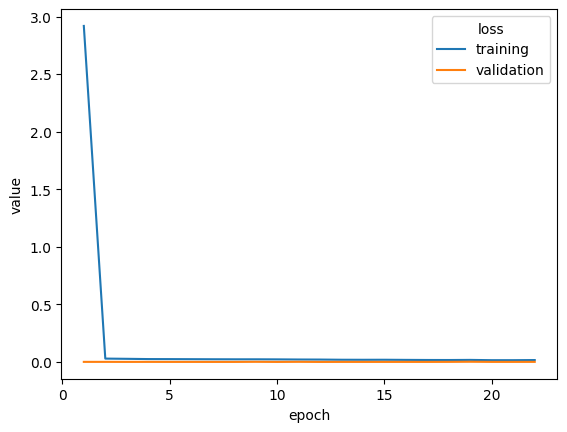

In [54]:
losses = pd.DataFrame(losses)

sns.lineplot(
    data=losses.melt(id_vars="epoch", var_name="loss"),
    x="epoch",
    y="value",
    hue="loss"
)

This eval function evaluates the trained model on the test dataset, calculating metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE). The metrics are returned as a dictionary for easy access.

In [55]:
def eval(model: LSTMModel, test_loader: DataLoader):
    model.eval()
    
    mse = []
    mae = []
    
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            targets = targets.unsqueeze(1)
            
            mse_i = F.mse_loss(outputs, targets, reduction='mean').item()
            mse.append(mse_i)

            mae_i = F.l1_loss(outputs, targets, reduction='mean').item()
            mae.append(mae_i)
    
    metrics = {
        "MSE": np.mean(mse),
        "RMSE": np.sqrt(np.mean(mse)),
        "MAE": np.mean(mae)
    }
    
    return metrics

After evaluating the model, the metrics are printed to understand the model's performance on the test set.

In [56]:
metrics = eval(model, test_loader)
metrics

{'MSE': 0.00010090353368598568,
 'RMSE': 0.01004507509608493,
 'MAE': 0.005092993445162263}

The collect_predictions function gathers predictions and actual values from the test set. These values are then rescaled back to the original units using the rescale function.

In [57]:
def collect_predictions(model: LSTMModel, data_loader: DataLoader) -> tuple:
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for features, targets in data_loader:
            outputs = model(features)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(targets.cpu().numpy().flatten())
    
    return predictions, actuals

def rescale(scaled: list, omin: float, omax: float) -> np.array:
    return [x * (omax - omin) + omin for x in scaled]

predictions, actuals = collect_predictions(model, test_loader)
predictions, actuals = rescale(predictions, omin=omin, omax=omax), rescale(actuals, omin=omin, omax=omax)

A scatter plot is created to compare the actual versus predicted values on the test set. The diagonal red dashed line represents perfect predictions, allowing us to visualize the prediction accuracy.

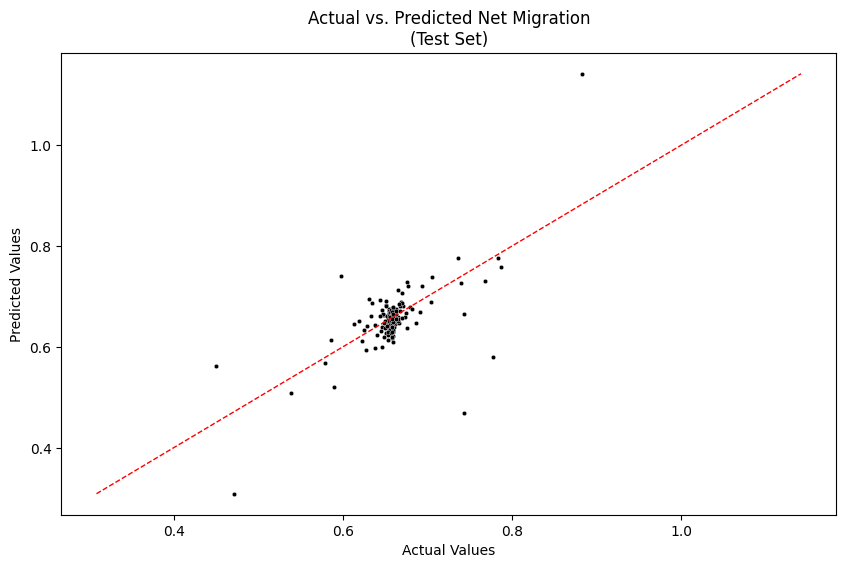

In [58]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals, y=predictions, color="black", s=10)

min_val = min(min(actuals), min(predictions))
max_val = max(max(actuals), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration\n(Test Set)')
plt.show()

Predictions and actual values are collected and rescaled for the training, validation, and test sets. These are combined into a single DataFrame, facilitating comparison across different data splits.

In [59]:
train_pred, train_act = collect_predictions(model, train_loader)
val_pred, val_act = collect_predictions(model, val_loader)

train_pred, train_act = rescale(train_pred, omin, omax), rescale(train_act, omin, omax)
val_pred, val_act = rescale(val_pred, omin, omax), rescale(val_act, omin, omax)

all_predictions = pd.concat([
    pd.DataFrame({"predicted": train_pred, "actual": train_act, "set": "training"}),
    pd.DataFrame({"predicted": val_pred, "actual": val_act, "set": "validation"}),
    pd.DataFrame({"predicted": predictions, "actual": actuals, "set": "testing"})
])

all_predictions['set'] = pd.Categorical(all_predictions['set'], categories=['testing', 'training', 'validation'])
all_predictions = all_predictions.sort_values('set').reset_index(drop=True)

A scatter plot is generated to compare the actual versus predicted values across training, validation, and test sets. Different colors are used to distinguish between the data splits.

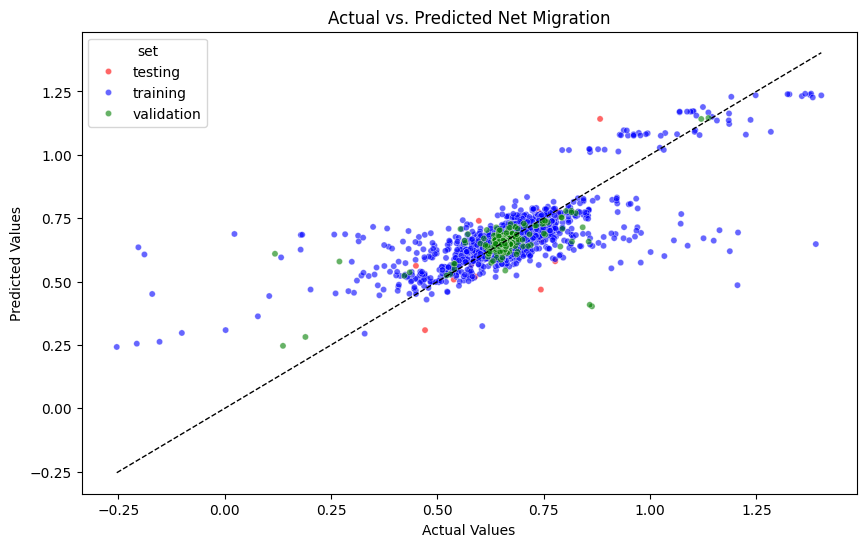

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=all_predictions, 
    x="actual",
    y="predicted",
    hue="set",
    palette={"testing": "red", "training": "blue", "validation": "green"},
    s=20, 
    alpha=0.6
)
# Main diagonal:
min_val = min(min(all_predictions["actual"]), min(all_predictions["predicted"]))
max_val = max(max(all_predictions["actual"]), max(all_predictions["predicted"]))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration')
plt.show()

Residuals (prediction errors) are plotted to assess the model's performance. This plot highlights whether there are any systematic errors or bias in the predictions.

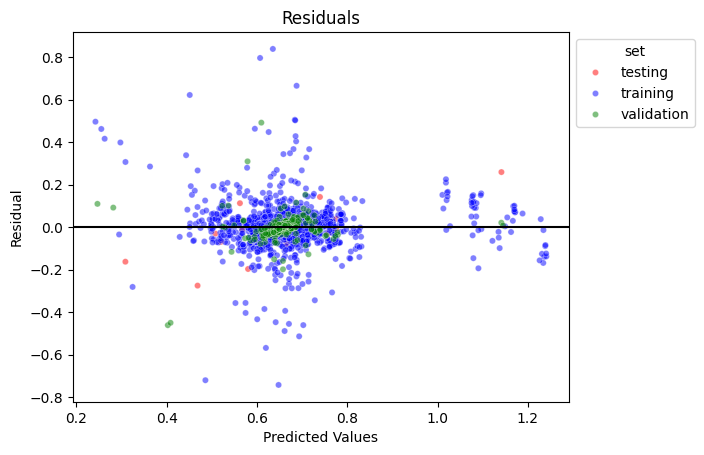

In [61]:
all_predictions["error"] = all_predictions["predicted"] - all_predictions["actual"]
ax = sns.scatterplot(
    data=all_predictions,
    x="predicted",
    y="error",
    hue="set",
    palette={"testing": "red", "training": "blue", "validation": "green"},
    s=20, 
    alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals')
plt.show()

This code evaluates the model's performance for each country by calculating the Mean Squared Error (MSE) on the combined validation and test datasets. The results are displayed, highlighting the countries with the highest and lowest MSE values.

In [62]:
combined_data = pd.concat([data_val, data_test])

countries = combined_data["iso3"].unique()

mse_results = {"country": [], "mse_combined": []}


# Function to collect predictions
def collect_predictions(model: LSTMModel, data_loader: DataLoader) -> tuple:
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for features, targets in data_loader:
            outputs = model(features)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(targets.cpu().numpy().flatten())
    
    return predictions, actuals

# Function to rescale data back to original units
def rescale(scaled: list, omin: float, omax: float) -> np.array:
    return [x * (omax - omin) + omin for x in scaled]

# Function to calculate MSE for a given country on the combined validation and test datasets
def calculate_mse_for_country_combined(country, data, seq_length, model):
    country_data = data[data["iso3"] == country]
    country_seqs = create_sequences(country_data, seq_length)
    country_set = MigrationDataset(country_seqs)
    country_loader = DataLoader(country_set, batch_size=32, shuffle=False)

    pred, act = collect_predictions(model, country_loader)
    pred = rescale(pred, omin, omax)
    act = rescale(act, omin, omax)
    
    mse = mean_squared_error(act, pred)
    return mse

# Loop through each country and calculate MSE on the combined validation and test datasets
for country in countries:
    # Combined set MSE
    mse_combined = calculate_mse_for_country_combined(country, combined_data, seq_length=1, model=model)
    
    # Store the results
    mse_results["country"].append(country)
    mse_results["mse_combined"].append(mse_combined)

# Convert the results to a DataFrame for easy analysis
mse_df = pd.DataFrame(mse_results)

# Sort the DataFrame by MSE
mse_df_sorted = mse_df.sort_values(by="mse_combined", ascending=False)

# Display the top 10 countries with the highest MSE
print("\nTop 10 countries with highest MSE on combined validation and test datasets:")
print(mse_df_sorted.head(10))

# Display the bottom 10 countries with the lowest MSE
print("\nBottom 10 countries with lowest MSE on combined validation and test datasets:")
print(mse_df_sorted.tail(10))


Top 10 countries with highest MSE on combined validation and test datasets:
    country  mse_combined
185     SYR      0.146457
205     VEN      0.089868
166     SAU      0.065204
202     USA      0.026978
145     NPL      0.020974
40      COL      0.019265
149     PAK      0.015238
196     TUR      0.011152
88      IND      0.010009
151     PER      0.007738

Bottom 10 countries with lowest MSE on combined validation and test datasets:
    country  mse_combined
115     LUX  3.539868e-06
130     MNE  3.475567e-06
47      CYP  3.306720e-06
170     SLB  2.490255e-06
14      BEL  2.059438e-06
28      BRN  1.837861e-06
79      GUM  5.542445e-07
110     LCA  3.196543e-07
76      GRD  2.690611e-07
18      BGR  2.495732e-07


In [71]:
import pandas as pd
import plotly.express as px


# Plotting the world map with the MSE data
fig = px.choropleth(
    mse_df,
    locations="country", 
    locationmode='ISO-3',  # Use the ISO-3 code for country identification
    color="mse_combined", 
    hover_name="country", 
    color_continuous_scale=px.colors.sequential.Plasma,
    title="MSE of LSTM Model Predictions by Country"
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)

fig.show()
